In [1]:
import os
import sys
import pandas as pd
import re
from collections import defaultdict
from datasets import Dataset

project_path = os.path.abspath(os.path.join(os.getcwd(), "../../project"))
if project_path not in sys.path:
    sys.path.append(project_path)

def clean(text):
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^\x00-\x7f]", " ", text)
    text = re.sub(r"\n{2,}", "\n", text)
    return text



df = pd.read_csv("UpdatedResumeDataSet.csv", encoding="utf-8")
df.drop_duplicates(subset=["Resume"], keep="first", inplace=True)
df.reset_index(inplace=True, drop=True)
df["Clean"] = df["Resume"].apply(clean)

/home/maximkim/projects/resume-screener/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


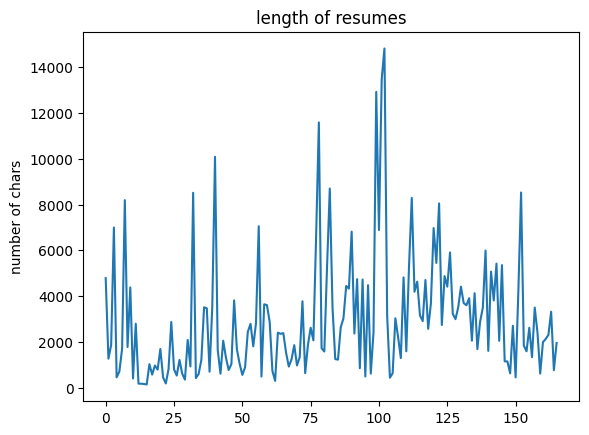

In [3]:
import matplotlib.pyplot as plt

lengths = []
for row in df["Clean"]:
    lengths.append(len(row))

plt.plot(lengths)
plt.title("length of resumes")
plt.ylabel("number of chars")
plt.show()



In [6]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
import numpy as np

model_name = "thenlper/gte-base"
embedding_model = HuggingFaceEmbeddings(model_name=model_name)
splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=300,
    chunk_overlap=50,
    length_function=len
)

To test this, reduce chunk_size and chunk_overlap from earlier

In [7]:
text = "hello there my guy you are such a guy dude guy yaya yaya"

def chunk_data(text):
    docs = splitter.create_documents(texts=[text])
    return [doc.page_content for doc in docs]

def embed_chunks(chunks):
    return embedding_model.embed_documents(chunks)

chunks = chunk_data(text)
print(chunks)
embedded = embed_chunks(chunks)
print(embedded)
    

['hello there my guy you are such a guy dude guy yaya yaya']
[[-0.0012243179371580482, -0.012970167212188244, 0.009754762053489685, 0.01901908405125141, 0.026360541582107544, 0.01002421323210001, 0.05536666885018349, 0.06483982503414154, -0.0386713445186615, -0.05845646187663078, -0.014085455797612667, 0.011918498203158379, -0.04137313738465309, 0.004030660726130009, -0.01570320874452591, 0.07356763631105423, 0.0717289000749588, 0.0019875227008014917, 0.02538578025996685, 0.005252043716609478, -0.004389476031064987, 0.0007696538814343512, 0.02632066421210766, 0.007194899953901768, 0.01464385911822319, -0.013764393515884876, -0.03364183381199837, 0.04402589797973633, -0.07076289504766464, -0.022726740688085556, 0.03516470640897751, 0.0017697386210784316, 0.012717185541987419, -0.039877038449048996, -0.04122520238161087, -0.020886186510324478, -0.010542161762714386, 0.006501904688775539, 0.005712909623980522, -0.018010180443525314, -0.02209196425974369, -0.013020895421504974, -0.02783213

In [8]:
from tqdm.notebook import tqdm
from time import time
df["Chunks"] = df["Clean"].apply(chunk_data)

def embed_chunks_map(sample):
    return {
        "Embeddings" : embed_chunks(sample["Chunks"])
    }

ds = Dataset.from_pandas(df)

start = time()
ds = ds.map(embed_chunks_map)
print(time() - start)

df = ds.to_pandas()
print(time() - start)
df

Map: 100%|██████████| 166/166 [04:00<00:00,  1.45s/ examples]


244.28631067276
244.29270029067993


,Category,Resume,Clean,Chunks,Embeddings
0,Data Science,Skills * Programming Languages: Python (pandas...,Skills * Programming Languages: Python (pandas...,[Skills * Programming Languages: Python (panda...,"[[0.012870321050286293, -0.015362934209406376,..."
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,Education Details \r\nMay 2013 to May 2017 B.E...,[Education Details \r\nMay 2013 to May 2017 B....,"[[0.02041386440396309, -0.019160505384206772, ..."
2,Data Science,"Areas of Interest Deep Learning, Control Syste...","Areas of Interest Deep Learning, Control Syste...","[Areas of Interest Deep Learning, Control Syst...","[[0.024425745010375977, 0.019275033846497536, ..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,Skills R Python SAP HANA Table...,[Skills R Python SAP HANA Tabl...,"[[0.007374039851129055, 0.012433740310370922, ..."
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...","Education Details \r\n MCA YMCAUST, Faridab...","[Education Details \r\n MCA YMCAUST, Farida...","[[0.025511810556054115, -0.03329212963581085, ..."
...,...,...,...,...,...
161,Testing,Computer Skills: â¢ Proficient in MS office (...,Computer Skills: Proficient in MS office (...,[Computer Skills: Proficient in MS office ...,"[[0.012022941373288631, 0.007987509481608868, ..."
162,Testing,â Willingness to accept the challenges. â ...,Willingness to accept the challenges. ...,[Willingness to accept the challenges. Pos...,"[[0.0018304360564798117, 0.002098105615004897,..."
163,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...","PERSONAL SKILLS Quick learner, Eagerne...","[PERSONAL SKILLS Quick learner, Eagern...","[[-0.00047142754192464054, 0.00413864105939865..."
164,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,[COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power...,"[[0.010268312878906727, 0.006651748437434435, ..."


In [15]:
ds

Dataset({
    features: ['Category', 'Resume', 'Clean', 'Chunks', 'Embeddings'],
    num_rows: 166
})

Embedding lengths are determined by model, so all will be the same

In [9]:
example = df["Embeddings"][0]
lengths = set([len(x) for x in example])
print(lengths)
EMBEDDING_LENGTH = list(lengths)[0]

{768}


Download postgres and run service


#### Statements to understand
```sql
CREATE TABLE name(
    val1 type1,
    val2 type2,
    val3 type3
)   
```
Create a table called name where each row (or record) keeps information on keys val1... with type type1...
```sql
INSERT INTO name (val1, val2, val3) VALUES (input1, input2, input3)
```
Insert the new record where val1 = input1, etc
```sql
SELECT * FROM name
```
Get every column of data for every row of name

In [ ]:

from random import randint
import psycopg
import os
from pgvector.psycopg import register_vector

from dotenv import load_dotenv
load_dotenv()

db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')


with psycopg.connect(
        dbname=db_name,
        user=db_user,
        password=db_password,
        host=db_host,
        port=db_port,
    ) as conn:
        with conn.cursor() as cur:
            print('hi')
            pass

hi


In [10]:
def to_pgvector(vec):
    return f"[{', '.join(map(str, vec))}]"

In [1]:
from random import randint
import psycopg
from pgvector.psycopg import register_vector


TABLE_NAME = "resume_docs"

def load_db(df):
    with psycopg.connect(
        dbname="postgres",
        user="postgres",
        password="password",
        host="localhost",  # Use localhost instead of a UNIX socket
        port="5432"
    ) as conn:
        # conn.autocommit = True
        with conn.cursor() as cur:
            cur.execute('CREATE EXTENSION IF NOT EXISTS vector')
            register_vector(conn)

            cur.execute(f"DROP TABLE IF EXISTS {TABLE_NAME}")
            cur.execute(
                f"""
                CREATE TABLE {TABLE_NAME}(
                    id serial PRIMARY KEY,
                    source_id integer,
                    chunk text,
                    embedding vector({EMBEDDING_LENGTH})
                )   
                """
            )

            for i, row in df.iterrows():
                embeds = row["Embeddings"]
                chunks = row["Chunks"]
                for j in range(len(embeds)):
                    vector_str = to_pgvector(embeds[j])
                    cur.execute(
                        f"INSERT INTO {TABLE_NAME} (source_id, chunk, embedding) VALUES (%s, %s, %s)", 
                        (i, chunks[j], vector_str)
                    )

            for x in cur.execute(f"SELECT id, source_id FROM {TABLE_NAME}"):
                print(x)

load_db(df)

NameError: name 'df' is not defined

#### Selecting top K for SQL

General form:
```sql
SELECT * FROM table_name ORDER BY expression LIMIT k
```
Sort table_name by some some expression eg. (arg1, |arg1 - input|). Take just the top K


For our use case, it will look like this:

```sql
SELECT * FROM resume_docs ORDER BY embedding <-> query::vector LIMIT k
```
Where we order by embedding <-> query::vector where <-> gets cosine similarity from each rows embedding to our query embedding, which we explicitly cast to vector with ::vector. Then we take k closest

This is how we embed our query

In [ ]:
query = "give me someone with software engineering experience"
query = embedding_model.embed_query(query)
print(query)
print(len(query))

In [ ]:
def get_top_k(prompt, k):
    embedded_prompt = embedding_model.embed_query(prompt)
    prompt_vec = to_pgvector(embedded_prompt)

    with psycopg.connect(
        dbname="postgres",
        user="postgres",
        password="password",
        host="localhost",
        port="5432"
    ) as conn:
        with conn.cursor() as cur:
            res = cur.execute(
                f"""
                SELECT *, embedding <-> %s::vector AS similarity
                FROM {TABLE_NAME}
                ORDER BY similarity
                LIMIT %s
                """,
                (prompt_vec, k)
            ).fetchall()
            return [
                {
                    "score": record[4],
                    "source_id": record[1]
                }
                for record in res
            ]

query = "experience with machine learning and data analytics"
k = 10
res = get_top_k(query, k)
print(res)

In [ ]:
from typing import List
# these 
def load_resumes(ids: List[int]):
    ids = list(set(ids))
    data = ""
    for id in ids:
        add = f"### Applicant ID {id}\n{df['Clean'][id]}\n\n"
        data += add
    return data

ids = [vals["source_id"] for vals in res]
print(load_resumes(ids))

In [ ]:
from openai import OpenAI
from dotenv import load_dotenv
import os
load_dotenv()
# print(os.environ["OPENAI_API_KEY"])

Calling openai sdk which deepseek and other non open ai models also use

In [ ]:
client = OpenAI()
completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user", 
            "content": "write a haiku about ai"
        }, # task or main prompt
        {
            "role": "developer", 
            "content": """You are a helpful assistant
                        that answers programming
                        questions in the style of a
                        southern belle from the
                        southeast United States."""
        }, # personality 
        {
            "role": "assistant", 
            "content": """Bits dance in the night,
                        logic weaves through lines of code,
                        dreams compile to life."""
        }, # reference responses 
    ],
    temperature=0, # how creative where 0 is deterministic
)

In [ ]:
print(completion)
print(completion.choices)
print(completion.choices[0])
print(completion.choices[0].message)

print()
print(completion.choices[0].message.content)

In [ ]:

def query(prompt, k=10):
    top_k = get_top_k(prompt, k)
    ids = [vals["source_id"] for vals in top_k]
    print(ids)
    context = load_resumes(ids)
    developer_prompt = "You are an expert in talent acquisition and tasked with analyzing and comparing a set resumes to select the best applicants for hire"
    query_prompt = f"""## Context:\n{context}\n\n## Query: {prompt}"""

    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user", 
                "content":  query_prompt
            }, # task or main prompt
            {
                "role": "developer", 
                "content": developer_prompt
            }, # personality 
        ],
        temperature=0, # how creative where 0 is deterministic
    )
    return completion.choices[0].message.content

prompt = "give me applicants with the most web development experience and explain why they would be fit for fast development"
res = query(prompt)

In [ ]:
print(res)